### Import libraries

In [1]:
import torch
from typing import Tuple, Dict, List
import pandas as pd
import csv
import json
from matplotlib import pyplot as plt
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from dataclasses import dataclass, field

/home/vignesh-pt6720/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option("display.max_colwidth", 300)

### Data loading and exploratory analysis

In [3]:
meta = pd.read_csv(
    "../../datasets/MovieSummaries/movie.metadata.tsv", sep="\t", header=None
)

In [4]:
meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [5]:
meta.columns = ["movie_id", 1, 2, 3, 4, 5, 6, 7, "genre"]
meta = meta[["movie_id", "genre"]]
meta["movie_id"] = meta["movie_id"].astype(str)
meta.head()

,movie_id,genre
0,975900,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,"{""/m/07s9rl0"": ""Drama""}"


In [6]:
rows = []
plots = []
movie_ids = []

# Read plot summaries
with open("../../datasets/MovieSummaries/plot_summaries.txt", "r") as f:
    reader = csv.reader(f, dialect="excel-tab")
    for row in reader:
        rows.append(row)

for i in rows:
    movie_ids.append(i[0])
    plots.append(i[1])

Combine plot summaries and genres

In [7]:
movies = pd.DataFrame({"movie_id": movie_ids, "plot": plots})
movies = pd.merge(movies, meta, on="movie_id")
movies.head()

,movie_id,plot,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...","{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}"


In [8]:
cleaned_genres = []
for i in movies["genre"]:
    cleaned_genres.append(
        list(json.loads(i).values())
    )  # Convert genres from json to list

movies["cleaned_genre"] = cleaned_genres

Remove data having no genres

In [9]:
print(f"Before: {movies.shape}")
movies = movies[(movies["cleaned_genre"].str.len() != 0)]
print(f"After: {movies.shape}")

Before: (42204, 4)
After: (41793, 4)


In [10]:
movies = movies.drop("genre", axis=1)  # Drop old genres
movies.head()

,movie_id,plot,cleaned_genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.","[Drama, World cinema]"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...","[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...","[Screwball comedy, Comedy]"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


In [11]:
all_genres = []
genre_freq = {}

for row in movies["cleaned_genre"]:
    for genre in row:
        if genre not in all_genres:
            all_genres.append(genre)
            genre_freq[genre] = 1
        else:
            genre_freq[genre] += 1

In [12]:
print(f"No. of unique genres(output class): {len(all_genres)}")

No. of unique genres(output class): 363


In [13]:
top_genres = dict(
    sorted(genre_freq.items(), key=lambda x: x[1], reverse=True)[:10]
)  # Find the top ten genres and sort them
top_genres

{'Drama': 19134,
 'Comedy': 10467,
 'Romance Film': 6666,
 'Thriller': 6530,
 'Action': 5868,
 'World cinema': 5153,
 'Crime Fiction': 4275,
 'Horror': 4082,
 'Black-and-white': 3731,
 'Indie': 3668}

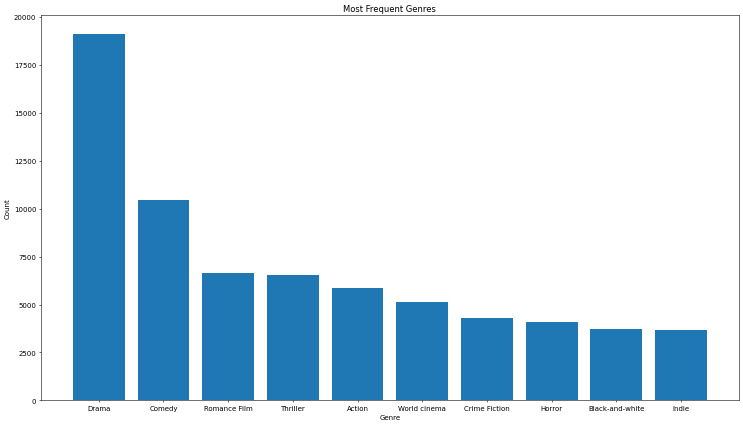

In [14]:
plt.subplots(figsize=(18, 10), dpi=50)
plt.title("Most Frequent Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.bar(top_genres.keys(), top_genres.values())
plt.show()

### Data preprocessing

In [15]:
def preprocess(text: str) -> str:
    """
    Function to preproces text

    Parameters
    ----------
    text: `str`
        Text that is to be preprocessed

    Returns
    -------
    text: `str`
        Preprocessed text
    """

    text = text.lower()
    text = text.translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )  # Remove punctuations
    text = re.sub(r"\d", "", text)  # Remove digits

    words = word_tokenize(text)
    stopwords_english = stopwords.words("English")
    for word in words:
        if word in stopwords_english:
            text = re.sub(r"\b%s\b" % word, "", text)  # Remove stop words

    text = re.sub(" +", " ", text)  # Remove extra spaces

    return text

In [16]:
print("Before cleanup: ", movies["plot"][0])
movies["plot"] = movies["plot"].map(preprocess)
print("After cleanup: ", movies["plot"][0])

Before cleanup:  Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.
After cleanup:  shlykov hard working taxi driver lyosha saxophonist develop bizarre love hate relationship despite prejudices realize different 


### Create word vocabulary

In [17]:
def create_vocab(df: pd.DataFrame) -> Dict[str, int]:
    """
    Function used to create a vocabulary of all words with their counts in the given corpus

    Parameters
    ----------
    df: `pd.DataFrame`
        Dataframe object containing the corpus

    Returns
    -------
    vocab: `Dict[str, int]`
        Vocabulary containing all words with their counts
    """

    vocab = {}
    stopwords_english = stopwords.words("English")
    for plot in df.values:
        words = word_tokenize(plot)
        for word in words:
            if word not in stopwords_english:
                if word not in vocab:
                    vocab[word] = 1
                else:
                    vocab[word] += 1

    return vocab

In [18]:
vocab = create_vocab(movies["plot"])

In [19]:
top_words = dict(
    sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:10]
)  # List top ten words
top_words

{'one': 32077,
 'back': 24375,
 'two': 22025,
 'film': 21235,
 'father': 21205,
 'man': 19735,
 'tells': 18937,
 'time': 18113,
 'life': 17588,
 'new': 17239}

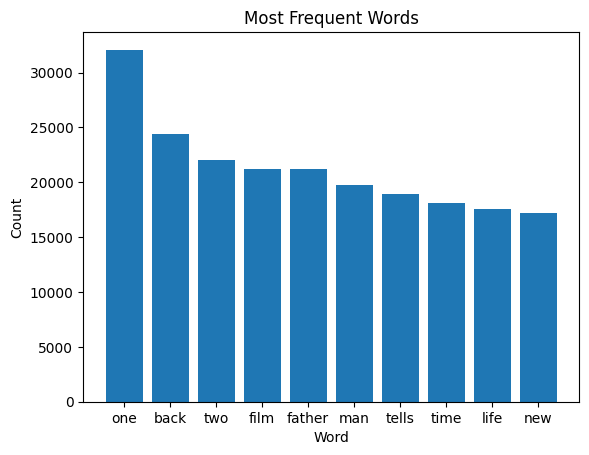

In [20]:
plt.bar(top_words.keys(), top_words.values())
plt.title("Most Frequent Words")
plt.xlabel("Word")
plt.ylabel("Count")
plt.show()

### Split data into train and test sets

In [21]:
train = movies.sample(frac=0.7)
test = movies.drop(train.index)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [22]:
all_genres = []
genre_freq = {}

for row in train["cleaned_genre"]:
    for genre in row:
        if genre not in all_genres:
            all_genres.append(genre)
            genre_freq[genre] = 1
        else:
            genre_freq[genre] += 1

print(f"No. of unique classes in training data: {len(all_genres)}")

No. of unique classes in training data: 360


Vectorizing data

In [23]:
# Vectorize input data

tfidf = TfidfVectorizer(max_features=10000)
tfidf.fit(train["plot"])
train_x = tfidf.transform(train["plot"])

In [24]:
# Vectorize output data

mb = MultiLabelBinarizer()
train_y = mb.fit_transform(train["cleaned_genre"])
train_y = torch.tensor(train_y)

In [25]:
# Convert sparse matrix to tensor

coo_train = train_x.tocoo()  # convert csr matrix to coordinate matrix
values = coo_train.data
indices = np.vstack((coo_train.row, coo_train.col))  # veritcally stack rows and columns
index = torch.LongTensor(indices)
value = torch.FloatTensor(values)
shape = coo_train.shape

train_x = torch.sparse.FloatTensor(index, value, torch.Size(shape)).to_dense()

In [26]:
train_x.shape, train_y.shape

(torch.Size([29255, 10000]), torch.Size([29255, 360]))

### Neural network for multilabel classification

In [36]:
def initialize_parameters(layer_dims: List) -> Dict[str, torch.Tensor]:
    """
    Initialize parameters for the neural network

    Parameters
    ----------
    layer_dims: `List`
       The number of neurons in each layer as a list
       Eg: [10000, 10, 360] => 3 layers with sizes 10000 (input), 10 (hidden), 360 (output)

    Returns
    -------
    params: `Dict[str, torch.Tensor]`
       The initial parameters for the neural network
    """

    params = {}

    for l in range(1, len(layer_dims)):
        params[f"W{l}"] = torch.rand(layer_dims[l], layer_dims[l - 1]) * 0.01
        params[f"b{l}"] = torch.zeros((layer_dims[l], 1))

    return params

In [37]:
def linear_forward(
    A_prev: torch.Tensor, W: torch.Tensor, b: torch.Tensor
) -> Tuple[torch.Tensor, Tuple]:
    """
    Computes the linear activation for given parameters

    Parameters
    ----------
    A_prev: `torch.Tensor`
        Activations of the previous layer
    W: `torch.Tensor`
        Weights of current layer
    b: `torch.Tensor`
        Bias of current layer

    Returns
    -------
    Z: `torch.Tensor`
        Linear activation of current layer
    cache: `Tuple`
        A tuple containing parameters to this function
    """

    Z = torch.mm(W, A_prev) + b
    cache = (A_prev, W, b)

    return Z, cache

In [38]:
def linear_activation_forward(
    A_prev: torch.Tensor, W: torch.Tensor, b: torch.Tensor, activation: str
) -> Tuple[torch.Tensor, Tuple]:
    """
    Function to compute linear and non-linear activation

    Parameters
    ----------
    A_prev: `torch.Tensor`
        Activations of the previous layer
    W: `torch.Tensor`
        Weights of current layer
    b: `torch.Tensor`
        Bias of current layer
    activation: `str`
        Type of activation function used in current layer

    Returns
    -------
    A: `torch.Tensor`
        Activations of the current layer
    cache: `Tuple`
        A tuple containing values required for back propagation
    """

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = torch.sigmoid(Z), Z
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = torch.relu(Z), Z
    cache = (linear_cache, activation_cache)

    return A, cache

In [39]:
def L_model_forward(
    X: torch.Tensor, params: Dict[str, torch.Tensor]
) -> Tuple[torch.Tensor, List]:
    """
    Computes one forward pass

    Parameters
    ----------
    X: `torch.Tensor`
        Input data
    params: `torch.Tensor`
        Parameters of the model

    Returns
    -------
        AL: `torch.Tensor`
            Activations of the final layer
        caches: `List`
            A list of values used for back propagation
    """

    caches = []
    L = len(params) // 2
    A_prev = X
    for l in range(1, L):
        A, cache = linear_activation_forward(
            A_prev, params[f"W{l}"], params[f"b{l}"], "relu"
        )
        caches.append(cache)
        A_prev = A

    AL, cache = linear_activation_forward(
        A_prev, params[f"W{L}"], params[f"b{L}"], "sigmoid"
    )
    caches.append(cache)

    return AL, caches

In [40]:
def compute_cost(AL: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    """
    Computes cost of the model. Uses cross-entropy loss

    Parameters
    ----------
    AL: `torch.Tensor`
        Activations of the final layer
    Y: `torch.Tensor`
        Actual values that are to be predicted

    Returns
    -------
    cost: `torch.Tensor`
        Cost of the model
    """

    cost = -torch.mean(
        (
            (Y * torch.log(AL).transpose(0, 1))
            + ((1 - Y) * torch.log(1 - AL).transpose(0, 1))
        )
    )

    return torch.squeeze(cost)

In [41]:
def linear_backward(dz: torch.Tensor, cache: Tuple) -> Tuple[torch.Tensor]:
    """
    Computes gradients of current later required for gradient descent

    Parameters
    ----------
    dz: `torch.Tensor`
        Gradient of linear activation Z of current layer
    cache: `Tuple`
        Cache containing values required for back propagation

    Returns
    -------
    dA_prev: `torch.Tensor`
        Gradient of activations of previous layer
    dw: `torch.Tensor`
        Gradient of weights of current layer
    db: `torch.Tensor`
        Gradient of biases of current layer
    """

    A_prev, w, b = cache
    m = A_prev.shape[1]
    dw = torch.mm(dz, A_prev.transpose(0, 1)) / m
    db = torch.sum(dz, axis=1, keepdims=True) / m
    dA_prev = torch.mm(w.transpose(0, 1), dz)

    return dA_prev, dw, db

In [42]:
def sigmoid_backward(dA: torch.Tensor, cache: Tuple) -> torch.Tensor:
    """
    Function to compute the gradient of linear activation

    Parameters
    ----------
    dA: `torch.Tensor`
        Gradient of activation function
    cache: `Tuple`
        Tuple containing values for back propagation

    Returns
    -------
    dz: `torch.Tensor`
        Gradient of linear activation
    """

    Z = cache
    s = 1 / (1 + torch.exp(-Z))
    dz = dA.transpose(0, 1) * s * (1 - s)

    return dz

In [43]:
def relu_backward(dA: torch.Tensor, cache: Tuple) -> torch.Tensor:
    """
    Function to compute the gradient of linear activation

    Parameters
    ----------
    dA: `torch.Tensor`
        Gradient of activations of current layer
    cache: `Tuple`
        Tuple containing values for back propagation

    Returns
    -------
    dz: `torch.Tensor`
        Gradient of linear activation
    """

    Z = cache
    dz = dA
    dz[Z <= 0] = 0

    return dz

In [ ]:
def linear_activation_backward(
    dA: torch.Tensor, cache: List, activation: str
) -> Tuple[torch.Tensor]:
    """
    Function to compute gradients

    Parameters
    ----------
    dA: `torch.Tensor`
        Gradient of activation layer
    cache: `List`
        List containing values for back propagation
    activation: `str`
        Type of activation used

    Returns
    -------
    dA_prev: ``torch.Tensor
        Gradient of activations of previous layer
    dw: `torch.Tensor`
        Gradient of weights of current layer
    db: `torch.Tensor`
        Gradient of biases of current layer
    """

    linear_cache, activation_cache = cache

    if activation == "relu":
        dz = relu_backward(dA, activation_cache)

    elif activation == "sigmoid":
        dz = sigmoid_backward(dA, activation_cache)

    dA_prev, dw, db = linear_backward(dz, linear_cache)

    return dA_prev, dw, db

In [ ]:
def L_model_backward(
    AL: torch.Tensor, Y: torch.Tensor, caches: List
) -> Dict[str, torch.Tensor]:
    """
    Computes one backward pass to calculate gradients required for gradient descent

    Parameters
    ----------
    AL: `torch.Tensor`
        Activations of the final layer
    Y: `torch.Tensor`
        Truth values
    caches: `List`
        List containing values for backpropgation

    Returns
    -------
    grads: `Dict[str, torch.Tensor]`
        Dictionary containing the gradients for all weights and biases
    """

    L = len(caches)
    m = Y.shape[1]
    grads = {}

    dAL = -(torch.div(Y, AL.transpose(0, 1)) - torch.div(1 - Y, 1 - AL.transpose(0, 1)))

    grads[f"dA{L-1}"], grads[f"dW{L}"], grads[f"db{L}"] = linear_activation_backward(
        dAL, caches[L - 1], "sigmoid"
    )
    for l in reversed(range(L - 1)):
        dA_prev, dw, db = linear_activation_backward(
            grads[f"dA{l+1}"], caches[l], "relu"
        )
        grads[f"dW{l+1}"] = dw
        grads[f"db{l+1}"] = db
        grads[f"dA{l}"] = dA_prev

    return grads

In [48]:
def update_parameters(
    params: Dict[str, torch.Tensor],
    grads: Dict[str, torch.Tensor],
    learning_rate: float,
) -> Dict[str, torch.Tensor]:
    """
    Function to perform gradeint descent

    Paramters
    ---------
    params: `Dict[str, torch.Tensor]`
        Parameters of the model that are to be updated
    grads: `Dict[str, torch.Tensor]`
        Gradients that are used to update paramters during gradient descent
    learning_rate: `float`
        Learning rate used to affect the rate of gradient descent

    Returns
    -------
    params: `Dict[str, torch.Tensor]`
        Updated parameters after gradient descent
    """

    L = len(params) // 2
    for l in range(1, L + 1):
        params[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        params[f"b{l}"] -= learning_rate * grads[f"db{l}"]

    return params

In [49]:
def predict(X_test: torch.Tensor, parameters: Dict[str, torch.Tensor]) -> torch.Tensor:
    """
    Function used to predict the output of given input data based on trained model

    Parameters
    ----------
    X_test: `torch.Tensor`
        Input data that is used to predictions
    parameters: `Dict[str, torch.Tensor]`
        Parameters used for predictions

    Returns
    -------
    predictions: `torch.Tensor`
        Predictions for given input data
    """

    AL, caches = L_model_forward(X_test, parameters)

    AL[AL < 0.5] = 0
    AL[AL >= 0.5] = 1

    return torch.squeeze(AL)

In [50]:
def draw(learning_rate: float, epochs: int, costs: List):
    """
    Function to draw the variation of cost over different epochs

    Parameters
    ----------
    learning_rate: `float`
        Learning rate used to affect the rate of gradient descent
    epochs: `int`
        Number of times the training samples are to be read / No. of iterations of model
    costs: `List`
        List containing costs in all epochs
    """

    plt.title("Learning rate = " + str(learning_rate))
    plt.plot(range(1, epochs + 1), costs)
    plt.xlabel("No. of iterations")
    plt.ylabel("Cost Function")
    plt.show()

In [51]:
def MultiLabelClassifier(
    X: torch.Tensor,
    Y: torch.Tensor,
    layers_dims: List,
    learning_rate: float = 0.1,
    epochs: int = 10,
    print_cost: bool = False,
    draw_cost: bool = False,
) -> Dict[str, torch.Tensor]:
    """
    Function that builds a neural network model for Multilabel Classification

    Parameters
    ----------
    X: ``torch.Tensor``
        Input data to the model
    Y: ``torch.Tensor``
        Output data used for supervised learning
    epochs: ``int`` ( default = 10 )
        Number of times the training samples are to be read / No. of iterations of model
    learning_rate: ``str`` ( default = 0.1 )
        Learning rate used to affect the rate of gradient descent
    print_cost: ``str`` ( default = False )
        Flag that determines if cost is to be printed while training the model
    draw_cost: ``str`` ( default = False )
        Flag that determines if a plot of cost function vs epoch is to be drawn
    params: ``str`` ( default = {} )
        Parameters of the model
    grads: ``str`` ( default = {} )
        Gradient of every parameter
    costs: ``str`` ( default = [] )
        List containing cost after each epoch
    """

    costs = []

    parameters = initialize_parameters(layers_dims)

    for i in range(0, epochs):
        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y)
        costs.append(cost)

        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost:
            print(f"Cost after iteration {i}: {cost}")

    if draw_cost:
        draw(learning_rate, epochs, costs)

    return parameters

### Test the model

Cost after iteration 0: 0.693968653678894
Cost after iteration 1: 0.669308066368103
Cost after iteration 2: 0.6466655731201172
Cost after iteration 3: 0.6251389384269714
Cost after iteration 4: 0.6046704649925232
Cost after iteration 5: 0.5852046012878418
Cost after iteration 6: 0.566688060760498
Cost after iteration 7: 0.5490697026252747
Cost after iteration 8: 0.5323009490966797
Cost after iteration 9: 0.5163353085517883


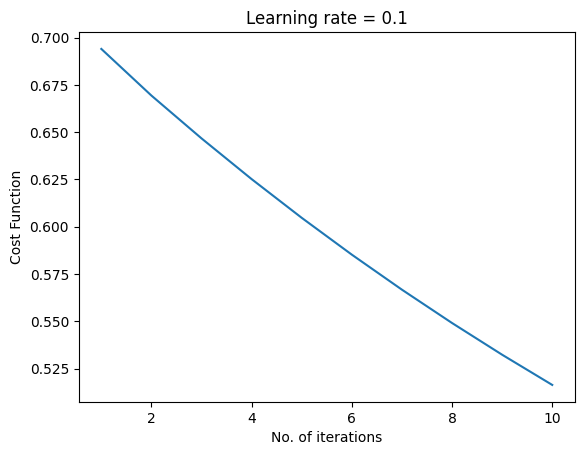

In [52]:
params = MultiLabelClassifier(
    train_x.transpose(0, 1),
    train_y,
    layers_dims=[10000, 10, train_y.shape[1]],
    epochs=10,
    print_cost=True,
    draw_cost=True,
)

### Testing the model

In [53]:
test_x = tfidf.transform(test["plot"])

coo_test = test_x.tocoo()
values = coo_test.data
indices = np.vstack((coo_test.row, coo_test.col))
index = torch.LongTensor(indices)
value = torch.FloatTensor(values)
shape = coo_test.shape

test_x = torch.sparse.FloatTensor(index, value, torch.Size(shape)).to_dense()
test_x = test_x.transpose(0, 1)

In [54]:
test_x.shape

torch.Size([10000, 12538])

In [55]:
predictions = predict(test_x, params)

In [56]:
predictions.shape

torch.Size([360, 12538])